# DeepAgro - Machine Learning Engineer - Desafío 1
#### *Autor: Patricio Carnelli*

## 1. Introducción

En este notebook voy a usar visualizaciones y métricas para decidir cuál de los cuatro modelos sacar a producción. Como paso preliminar, voy a realizar un análisis exploratorio de datos (AED).

## 2. Análisis exploratorio de datos

Empiezo importando los datos y con un análisis muy preliminar usando algunos comandos de `pandas`.

In [1]:
import pandas as pd

# Importar datos
data_raw = pd.read_csv('../data/Datos - Raw.csv')

In [2]:
data_raw.head()

,Objeto,Clase,SubClase,Especie,Modelo_A,Modelo_B,Modelo_C,Modelo_D
0,1,Weed,Grass,Specie 5,Si,Si,Si,Si
1,2,Weed,Broadleaf,Specie 5,No,Si,No,Si
2,3,Weed,Grass,Specie 3,Si,Si,No,Si
3,4,Weed,Broadleaf,Specie 2,Si,Si,No,Si
4,5,Weed,Grass,Specie 2,Si,Si,Si,Si


In [3]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Objeto    408 non-null    int64 
 1   Clase     408 non-null    object
 2   SubClase  408 non-null    object
 3   Especie   408 non-null    object
 4   Modelo_A  408 non-null    object
 5   Modelo_B  408 non-null    object
 6   Modelo_C  408 non-null    object
 7   Modelo_D  408 non-null    object
dtypes: int64(1), object(7)
memory usage: 25.6+ KB


Antes de continuar, voy a convertir a *SubClase* y *Especie* en variables categóricas.

In [4]:
data_raw['SubClase'] = data_raw['SubClase'].astype('category')
data_raw['Especie'] = data_raw['Especie'].astype('category')

Podría continuar el AED usando `pandas` y `matplotlib` (o `seaborn` o `plotly`). Pero prefiero usar el paquete `ydata-profiling` (antes conocido como `pandas profiling`), el cual provee una herramienta completa y sencilla de usar.

*Nota*: Por alguna razón, que todavía no comprendo, los reportes de `ydata-profiling` no son mostrados al visualizar el notebook en github. Como solución alternativa, el notebook genera un archivo HTML del reporte que se encuentra en el directorio `reportes` (archivo `desafio1_aed.html`) y que se puede visualizar en este [enlace](https://raw.githack.com/pcarnelli/deepagro-ml-desafios/main/reports/desafio1_aed.html). Lamento el inconveniente.

In [5]:
from ydata_profiling import ProfileReport

aed_reporte = ProfileReport(data_raw,
                            title='Datos - Raw',
                            progress_bar=False,
                            samples=None,
                            correlations=None,
                            missing_diagrams=None,
                            interactions=None,
                            )

# Muestra el reporte en el notebook
aed_reporte.to_notebook_iframe()

# Bug: El reporte no se muestra cuando se visualiza el notebook desde github
# Solución alternativa: guardar el reporte en un archivo HTML
aed_reporte.to_file('../reports/desafio1_aed.html')

El conjunto de datos parece estar limpio (no tiene ceros, ni datos faltantes, ni otras anomalías evidentes). Esto es de esperarse ya que fue usado para entrenar/validar los modelos.

Es interesante notar que tanto *SubClase* como *Especie* no están uniformemente distribuidas.

## 3. Análisis de métricas

Dado que se trata de un problema de clasificación, la primera métrica que surge como opción es la *exactitud* (*accuracy*, en inglés). Más allá de las dificultades que tiene esta métrica cuando hay un desbalance de clases, con los datos disponibles en este caso no puedo calcular esta métrica (pues no tengo los datos correspondientes a los "verdaderos negativos").

Con la información disponible, y asumiendo que tengo todos los datos correspondientes a los "verdaderos positivos", puedo calcular la métrica de *sensibilidad* (*sensitivity*, *recall* o *true positive rate*, en inglés). Esta métrica, que de ahora en adelante llamaré *TPR*, estima la probabilidad de que el clasificador haya identificado positivamente una maleza, condicional a que realmente se trate de una maleza. Es decir, el *TPR* informa la capacidad del clasificador de identificar correctamente a las malezas.

Para calcular la métrica *TPR* defino la función `calcular_tpr`.

In [6]:
def calcular_tpr(df):
    
    modelos = ['Modelo_A', 'Modelo_B', 'Modelo_C', 'Modelo_D']
    positivos_reales = df.shape[0]
    
    tpr_dict = {}
    for modelo in modelos:
        tpr_dict[modelo] = sum(df[modelo]=='Si')/positivos_reales

    return pd.DataFrame([tpr_dict])

Uso esta función para calcular el *TPR* de cada modelo y luego muestro los resultados en un gráfico de barras.

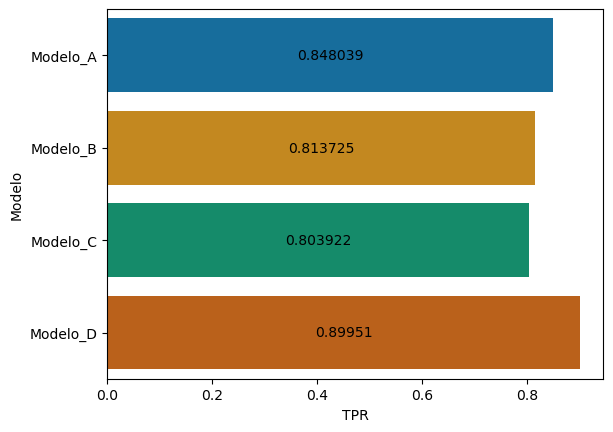

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

tpr = calcular_tpr(data_raw)

ax = sns.barplot(tpr,
                 palette='colorblind',
                 orient='h',
                 )
ax.set(xlabel='TPR', ylabel='Modelo')
for i in ax.containers:
    ax.bar_label(i, label_type='center')

Si me quedo únicamente con la información dada por la *TPR*, diría que el Modelo_D es el que debería ir a producción. Pero dado que cuento con el dato adicional de la métrica *true negative rate* (también conocida como *specificity* en inglés o *especificidad* en español), debería tenerla en consideración también.

La métrica *true negative rate*, de ahora en adelante *TNR*, es una estimación de la probabilidad de que el clasificador haya identificado negativamente una maleza, condicional a que realmente se trate de una maleza. Es decir, indica la capacidad del clasificador de reconocer cuando una planta realmente no es una maleza.

De la *TNR* se deriva fácilmente la *tasa de falsos positivos* (*false positive rate*, en inglés). Esta métrica, de ahora en adelante *FPR*, se calcula como 1-*TNR* y estima la probabilidad de que el clasificador identifique positivamente a una observación que en realidad no corresponde a una maleza (usualmente llamada probabilidad de "falsa alarma" o de "error de tipo I"). Como específicamente se menciona en el enunciado, la métrica *FPR* es muy importante en este caso porque mientras más alto sea su valor, se desperdiciará una mayor cantidad de productos químicos.

Según los datos provistos, el Modelo_D es el que muestra la mayor *FPR* (0,25) y el Modelo_A es el de menor *FPR* (0,05). Mientras que el Modelo_B y el Modelo_C tienen valores similares de *FPR* (0,09 y 0,08, respectivamente) y cercanos al del Modelo_A.

Entonces, la conclusión de cuál modelo debería ir a producción sería diferente si considero la *TPR* o la *FPR*. Una posibilidad para combinar la información provista por ambas métricas, es utilizar otra métrica conocida como el *índice de Youden* (*Youden's J statistic* o *informedness*, en inglés). Esta métrica, de ahora en adelante *J*, se calcula como *TPR*-*FPR* (o *TPR*+*TNR*-1). En principio, la métrica *J* puede tomar valores entre -1 y 1, donde 1 corresponde a un clasificador perfecto, 0 a un clasificador al azar y -1 a un clasificador donde las etiquetas de la variable objetivo están invertidas (por lo que en la práctica los valores encontrados están entre 0 y 1).

La métrica *J* se puede interpretar como la distancia entre un punto de la curva de *TPR* vs *FPR* (la curva *ROC*) y la línea del "azar" (la recta cuyos puntos cumplen la condición *TPR* = *FPR*). Desde el punto de vista de la curva *ROC*, mientras más alejadas estén las métricas de un clasificador de la línea del azar, mejor será su performance.

A continuación, calculo y grafico los valores de *J* para cada modelo.

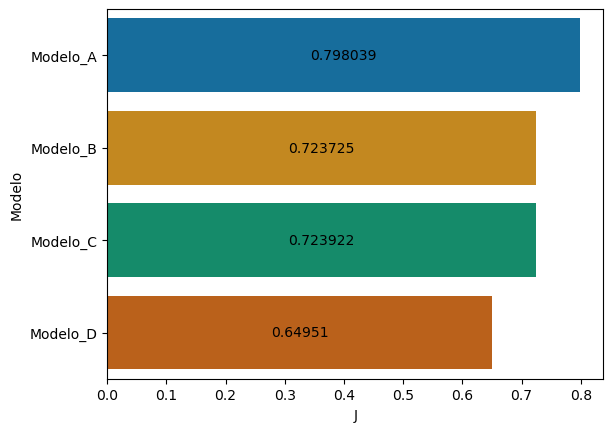

In [8]:
tnr = [0.95, 0.91, 0.92, 0.75]
J = tpr + tnr - 1

ax = sns.barplot(J,
                 palette='colorblind',
                 orient='h',
                 )
ax.set(xlabel='J', ylabel='Modelo')
for i in ax.containers:
    ax.bar_label(i, label_type='center')

Entonces, condensando la información que provee la *TPR* y la *TNR* en *J*, parecería que debería poner en producción el Modelo_A, que no tiene la mejor *TPR* pero sí la mejor *TNR*. Por su parte, según *J* la performance del Modelo_D es la peor entre los cuatro modelos, debido a su baja *TNR*, a pesar de tener la mejor *TPR*. Finalmente, de acuerdo al análisis realizado hasta ahora, las performances del Modelo_B y del Modelo_C son muy parejas, al ser todas sus métricas similares.

Antes de tomar una decisión, todavía queda un tema importante para analizar, al que se hace referencia explícita en el enunciado. Lo que sucede es que hasta ahora analicé la performance global de cada modelo, la cual podría variar significativamente entre lotes con diferentes distribuciones de tipos de malezas.

Para el análisis siguiente, defino la función `calcular_tpr_categoria` que calcula la *TPR* por separado para cada valor de una categoría dada.

In [9]:
def calcular_tpr_categoria(df, categoria):

    # Calcula la TPR para cada valor de la categoria
    resultados = pd.DataFrame()
    etiqueta = []
    for valor in df[categoria].unique():
        etiqueta.append(valor)
        resultados = pd.concat([resultados,
                               calcular_tpr(df[df[categoria]==valor])],
                               ignore_index=True,
                               )
    
    # Agrega al resultado de la TPR la etiqueta de la categoría correspondiente
    resultados = pd.concat([pd.Series(etiqueta), resultados], axis=1)
    resultados = resultados.rename(columns={0:'Categoria'})

    # Reformatea el dataframe de resultados para facilitar el uso de seaborn
    resultados = pd.melt(resultados,
                        id_vars=['Categoria'],
                        value_vars=['Modelo_A','Modelo_B','Modelo_C','Modelo_D'],
                        var_name='Modelo',
                        value_name='TPR',
                        )
    resultados['Categoria'] = resultados['Categoria'].astype('category')

    return resultados

Lo que quiero ver es qué tan diferentes son las *TPR* si las calculo para las distintas sub-clases y especies.

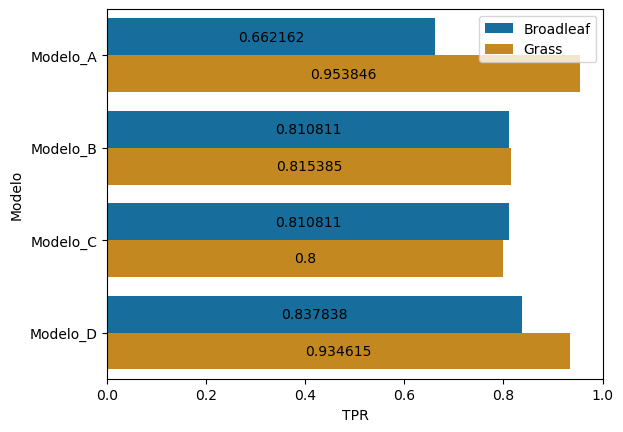

In [10]:
tpr_subclase = calcular_tpr_categoria(data_raw, categoria='SubClase')

ax = sns.barplot(tpr_subclase,
                 x='TPR',
                 y='Modelo',
                 hue='Categoria',
                 palette='colorblind',
                 orient='h',
                 )
ax.set(xlabel='TPR', ylabel='Modelo')
for i in ax.containers:
    ax.bar_label(i, label_type='center')
plt.gca().legend().set_title('')

Claramente, los modelos más balanceados teniendo en cuenta ambas sub-clases son el Modelo_B y el Modelo_C.

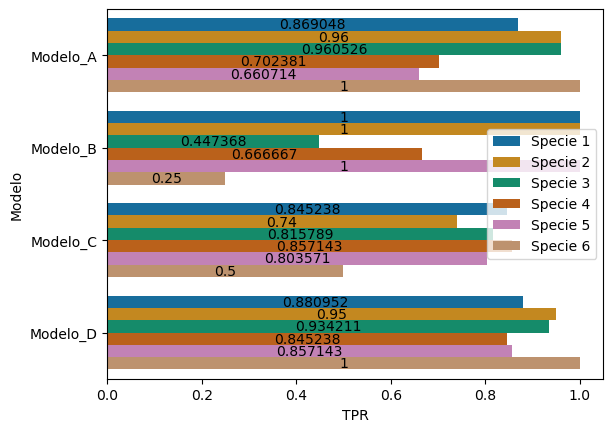

In [11]:
tpr_especie = calcular_tpr_categoria(data_raw, categoria='Especie')

ax = sns.barplot(tpr_especie,
                 x='TPR',
                 y='Modelo',
                 hue='Categoria',
                 palette='colorblind',
                 orient='h',
                 )
ax.set(xlabel='TPR', ylabel='Modelo')
for i in ax.containers:
    ax.bar_label(i, label_type='center')
plt.gca().legend().set_title('')

Teniendo en cuenta las especies por separado, el modelo más balanceado es el Modelo_C.

## 3. Conclusiones

Si bien el Modelo_D es el de mejor *TPR* tiene la *TNR* más baja y la *J* más baja, también. Por lo tanto, no será eficiente a la hora de ahorrar productos químicos.

Siguiendo en orden descendiente de *TPR*, el segundo mejor modelo es el Modelo_A. Éste tiene además la mejor *TNR*. De esta manera, es el modelo que tiene la mejor *J* y, por lo tanto, es uno de los candidatos más fuertes para la entrada en producción.

Sin embargo, no puedo dejar de lado al Modelo_B ni al Modelo_C. Ambos presentan valores muy buenos de las tres métricas analizadas (*TPR*, *TNR* y *J*). Además, sus performances son muy similares y cercanas a la del Modelo_A.

Las métricas de performance globales se corresponderían directamente con la situación de un lote donde estén las seis especies de malezas. Pero, dado que pueden existir lotes con menos especies (incluso con una sola), tengo que tener en cuenta la performance por sub-clase y por especie. Es en esta instancia que los modelos "rezagados" (el Modelo_B y el Modelo_C) cobran valor ya que muestran una performance más balanceada para ambas sub-clases. Más aún, el Modelo_C muestra una performance más balanceada que el Modelo_B cuando se analizan las seis especies por separado.

Por lo tanto, teniendo en cuenta el análisis completo, mi opinión es que hay que poner en producción el Modelo_C.

Cabe aclarar que esta recomendación podría cambiar si se especificaran criterios adicionales sobre valores mínimos de *TPR* globales o para alguna maleza en particular.